[![AnalyticsDojo](../fig/final-logo.png)](http://rpi.analyticsdojo.com)
<center><h1>Pytorch with the MNIST Dataset - MINST</h1></center>
<center><h3><a href = 'http://rpi.analyticsdojo.com'>rpi.analyticsdojo.com</a></h3></center>


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rpi-techfundamentals/spring2019-materials/blob/master/11-deep-learning1/04_pytorch_mnist.ipynb) 


# PyTorch Deep Explainer MNIST example

A simple example showing how to explain an MNIST CNN trained using PyTorch with Deep Explainer.

Adopted from: https://www.kaggle.com/ceshine/pytorch-deep-explainer-mnist-example


### Install the modified SHAP package

In [3]:
!pip install https://github.com/ceshine/shap/archive/master.zip

     | 74.1MB 155.9MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-xug5_6wp/wheels/8a/28/17/098d434a3f59f8529cb0ea4729568482332eef9127589ae8a8
Successfully built shap


### Proceed

In [0]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

## Set Parameters for Neural  Network
- Convolutional Neural network followed by fully connected. 

In [0]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [5]:

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 16384/9912422 [00:00<01:09, 142596.08it/s]

9920512it [00:01, 5952554.71it/s]                             


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 432289.05it/s]
0it [00:00, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5457348.83it/s]                           
8192it [00:00, 175134.12it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302780
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.191153
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.284060
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.900758
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.818337

Test set: Average loss: 0.0050, Accuracy: 8891/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.652153
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.740618
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.725341
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.542940
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.454126

Test set: Average loss: 0.0029, Accuracy: 9300/10000 (93%)



In [0]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [0]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

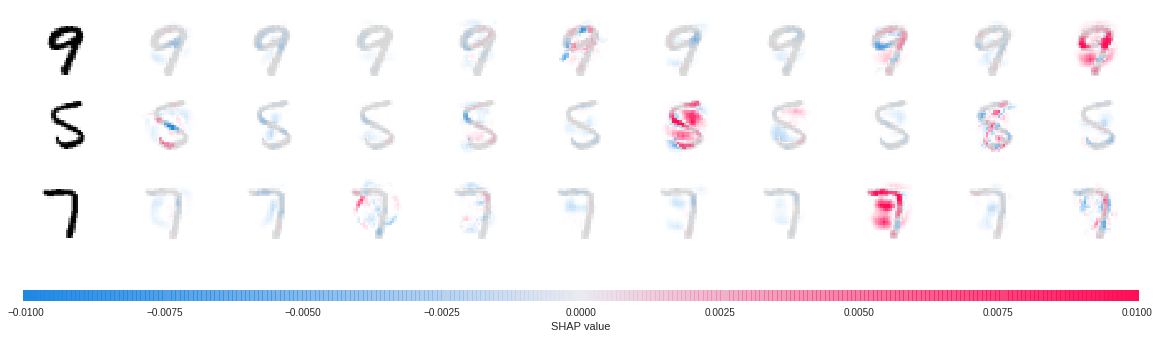

In [8]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

The plot above shows the explanations for each class on four predictions. Note that the explanations are ordered for the classes 0-9 going left to right along the rows.